In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline


from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm


challenge_data_folder = "./challenge_data"

from minisom import MiniSom

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cleaning

In [2]:
pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
#Categ indicates that no label encoding has been performed, the categorical features are untouched
columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name


At a first, the only information we have on the data set resides in the description file therefore we tried to match the data and the description file to make sure the data is clean and clear. One must first match features names and then specified values in the description file and in the dataset.

In [3]:
##Data cleaning
def dataCleaning(description_file_Path):
    """Checks in the data for not mentioned values in the description file given."""
    pathDescr = (challenge_data_folder+description_file_Path)
    txtDescripData = open(pathDescr).readlines()
    columnValues={}
    columnIndex=[]
    nbHeader = 7
    NoHeaderTxtDescripData = txtDescripData[nbHeader:]
    #Parse the description file to retrieve all the lines that corresponds to features    
    for feature in columnNames:
        if feature == 'Id': continue
        for index,line in enumerate(NoHeaderTxtDescripData):
            if feature in line: #Match features name and stated name in the description
                if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                    columnIndex.append((feature,index)) #We retrieved the line where the feature is described
                pass

    NoSpecificValfeatures = []
    SpecificVal = {} #Will contain as keys column names and values the specified values in the description file
    
    #Scan the cocument to retrieve specfic values for each featurz
    for index,featureLine in enumerate(columnIndex):

        startLine= featureLine[1]+2  #RTF file format 
        if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
        else: endLine = columnIndex[index+1][1]-1
        values = []
        if endLine <= startLine: #No specified value in the description file
            NoSpecificValfeatures.append(featureLine[0])
            continue
        for i in range(startLine,endLine):
            line = NoHeaderTxtDescripData[i] 
            values.append(line.split('\t')[0].strip())
        SpecificVal[featureLine[0]]=values #All values specified are retrieved and kept in this dictionary
        
    #Retrieve Bad values for the columns with specified values
    dicBadValues = []
    for factor in SpecificVal:

        #For a factor search for any value not specified in the description file 
        #In terms of type of valu

        typeCol = columnTypesDict[factor]
        if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
        else: valSpec = SpecificVal[factor]
        pdInter = pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)
        potentialBadValues = pdAllData_Categ[pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)]
        nbBadVal = len(potentialBadValues)

        if nbBadVal>0:
            badValues = [factor]
            badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
            dicBadValues.append(badValues)
    #Retrieve Bad values for the columns with not specified values such as year of construction of 

    for feature in NoSpecificValfeatures:
        dtypeColumn = columnTypesDict[feature]
        if dtypeColumn=='float64': typeFun = float #infered type -> check if any values do not convert to this type
        elif dtypeColumn=='int64': typeFun = int
        else: typeFun=lambda x: True
        pdInter = pdAllData_Categ[pdAllData_Categ.apply(lambda x: (x[feature]=='NA') and typeFun(x[feature]) ,axis=1)]
        if len(pdInter)>0:
            badValues=[feature]
            badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
            dicBadValues.append(badValues)
    return SpecificVal,NoSpecificValfeatures,dicBadValues

In [4]:
bad_description_file_Path = "/Bad_Description.rtf"
bad_specificVal,bad_noSpecificValfeatures,bad_dicBadValues = dataCleaning(bad_description_file_Path)
bad_dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [5]:
description_file_Path = "/Data description.rtf"
SpecificVal,NoSpecificValfeatures,dicBadValues = dataCleaning(description_file_Path)
print(NoSpecificValfeatures)
dicBadValues

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [6]:
print('When GarageYrBlt = NA, GarageType has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


In [7]:
print('When LotFrontage = NA, Alley has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.LotFrontage=='NA',axis=1)].Alley.values))

When LotFrontage = NA, Alley has values  {'NA', 'Grvl', 'Pave'}


<div class='alert alert-warning'>
First of all, some column names were wrong in the description file erors. By deducing form the data, we changed 
Bedroom to BedroomAbvGr and 
Kitchen to KitchenAbvGr.<br>

There are also errors in the values described.<br>
Most errors with the initial description are easily corrected by slighlty modifying the description file but some are more complex and persist such as :<br>
<li>C(all)</li>
<li>Twnhs</li>
They have no direct typo or writings and the other values pecified are included in the data.<br>
Although those values are not explicit in the description file, they contain information so we decided to keep them eventhough no direct explainition of those category is available.<br>
<br>
Otherwise, the other NA values can contain information or be explained by other specified values. The two cases above state that when a property has no garage, the year the garage has been built is not available and no MasVnrType implies no MasVnrArea which is reasonable but important to take into account.<br>

To conclude on this, no purely invalid values have been spotted in the data. Plus the NA values are hard to distinguish between not measured or simply absent of the good that's why we decieded to keep them.
</div>


## Encoding Categorical Features 

In [9]:
hist = plt.hist(pdAllData_Categ.SalePrice,cumulative=True,normed=True,bins='auto')

def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]
def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)
colors = pdAllData_Categ.apply(normHist,axis=1) #Color the points in function of the sale price with a gradient guided by the cumulated histogramm
plt.clf()
plt.close()

<div class='alert alert-warning'>
        &emsp; The data may be clean, it contains unconsistent datatype; strings, int and float. However, as mentioned before, we decided to use a tree model to solve this problem and tree models give exceeding results on datasets with numerical features. Therefore the first step of our pipeline is to transform string values to numbers which is encode categorical features.<br>
        &emsp;Encoding categorical features consists in transforming discrete string values to numerical values . To do so, many techniques exists, we decided to study two approches: label encoding and one hot encoding.<br><br>
        &emsp;Label encoding consists in simply associating to a string value of a categorical feature to a int. For exemple, the Alley featurn has possible values Grvl, Pave and NA. A possible encoding would replace all Grvl values by 0, Pave values by 1 and NA values by 2. The main disadvantage of this simple technique is that it introduces an order between the numerical values that can lead to misinterpretation by the model of this feature.<br>
        &emsp;The one-hot encoding tries to cope with this problem by intoducing dummy variable. In short, for each possible values, we introduce a new column which values will be 1 where the original features had this value in the frist place 0 otherwise. In the case of the alley, we would add three column Alley_Pave, Alley_Grvl and Alley_NA. If a house has no alley then we would have 0 in Alley_Pave and Alley_Grvl and a 1 in the Alley-NA column. In the special case where the feature has only two possible values, there is no need to add a column, we simply choose one value to be 0 and the other to be 1.
</div>

In [10]:
def encodeCategoricalFeatures(Data,labelEncode=True,oneHotEncode=False):
    """Encode the input dataframe Data using the label or one hot encoding technique """
    data_frames =[]
    if labelEncode: #Label Encoding technique
        lb_make = LabelEncoder() #Sklearn automatic encoder
        for featureCol in Data:
            if Data[featureCol].dtype=='object': #Categorical Feature
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    elif oneHotEncode:
        for featureCol in Data:
            if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
                lb_style = LabelBinarizer()
                lb_results = lb_style.fit_transform(Data[featureCol])
                if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
                else: columnsNames = lb_style.classes_ #One columnfor each possible values 

                lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
                data_frames.append(lb_results)
            elif Data[featureCol].dtype=='object': #NA values in a number column
                lb_make = LabelEncoder()
                data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
            else:
                data_frames.append(Data[featureCol])
    else: raise Exception('Choose an encoding technique labelEncode=True or oneHotEncode=True')
    return pd.concat(data_frames,axis=1)    
 

In [24]:
pdAllData = encodeCategoricalFeatures(pdAllData_Categ,labelEncode=True,oneHotEncode=False)
pdAllData_oneHot = encodeCategoricalFeatures(pdAllData_Categ,labelEncode=False,oneHotEncode=True)
print(pdAllData.shape,pdAllData_oneHot.shape)
pdAllData.head()
X = pdAllData.drop(['Id','SalePrice'],axis=1)
Y = pdAllData.SalePrice
X_scaled_array = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array,columns=list(X.columns.values))

(1200, 81) (1200, 293)


In [25]:
pdAllData_oneHot.head()

Id  MSSubClass  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
0   1          60                 0            0            0            1   
1   2          20                 0            0            0            1   
2   3          60                 0            0            0            1   
3   4          70                 0            0            0            1   
4   5          60                 0            0            0            1   

   MSZoning_RM  LotFrontage  LotArea  Street_Street    ...      SaleType_New  \
0            0           71     8450              1    ...                 0   
1            0           86     9600              1    ...                 0   
2            0           74    11250              1    ...                 0   
3            0           66     9550              1    ...                 0   
4            0           90    14260              1    ...                 0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  SalePrice  
0                      0     208500  
1                      0     181500  
2                      0     223500  
3                      0     140000  
4                      0     250000  

[5 rows x 293 columns]

## Outlier Detection

In [26]:
outliers_fraction = 0.05

def findOutliers_IsolationForest(outlierDetectionData, X, Y,outliers_fraction):
    clf = IsolationForest(max_samples=len(outlierDetectionData), contamination=outliers_fraction, random_state=42)
    clf.fit(outlierDetectionData)
    scores_pred = clf.decision_function(outlierDetectionData)
    y_pred = clf.predict(outlierDetectionData)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    outliers_index = np.where(y_pred==-1)[0]
    X_inlier, Y_inlier = X.drop(outliers_index,axis=0),Y.drop(outliers_index,axis=0)
    X_outlier, Y_outlier = X.filter(outliers_index,axis=0),Y.filter(outliers_index,axis=0)
    return scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier

In [27]:
def plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier):
    plt.figure(figsize=(16,10))
    plt.subplot(321)
    scores_pred_sorted = np.sort(scores_pred)
    plt.plot([0,1199],[threshold]*2,'--',c='red')
    plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
    plt.subplot(322)
    plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
    ax = plt.subplot(3,1,(2,3))
    inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
    outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])
    plt.xlabel('SalePrice')
    plt.ylabel('Outlier Score')
    plt.scatter(Y_inlier,inlier.T[1],marker="o",c=colors.filter(inlier.T[0]),cmap=cmap,label="Inliers")
    plt.scatter(Y_outlier,outlier.T[1],marker="^",c=colors.filter(outlier.T[0]),cmap=cmap,label="Outliers")
    for i in range(len(Y_outlier)): ax.annotate(Y_outlier.iloc[[i]].keys()[0],(Y_outlier.iloc[[i]].values[0],outlier.T[1][i]))
    plt.plot([0,750000],[threshold]*2,'--',c='red')
    #plt.colorbar()
    plt.legend()
    plt.show()

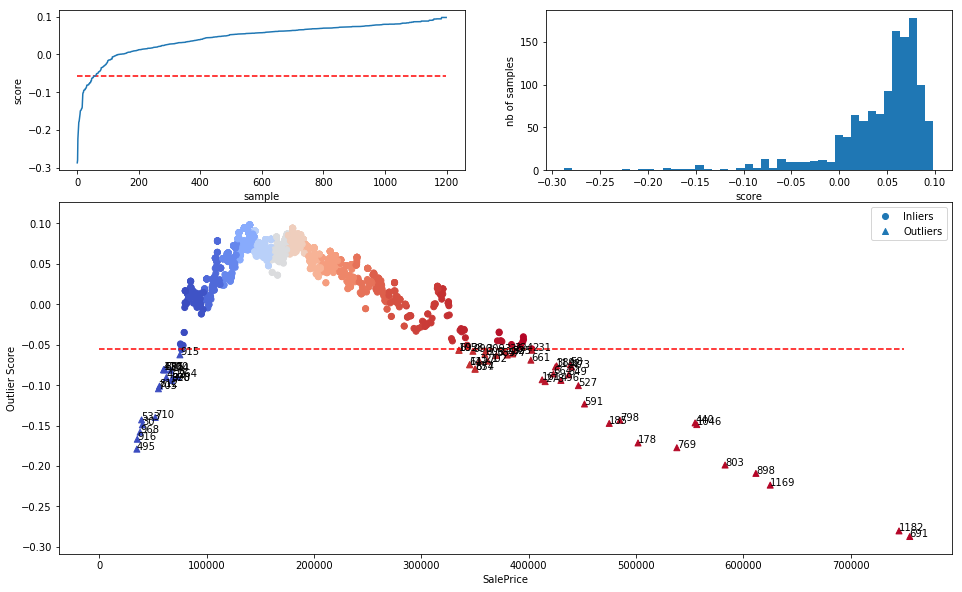

In [28]:
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(Y.values.reshape(-1,1),X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

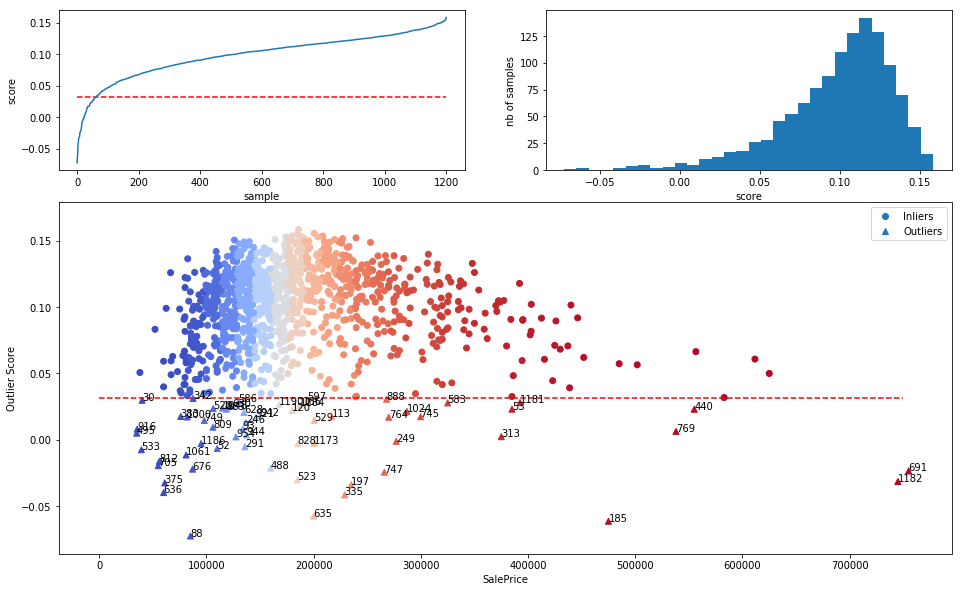

In [29]:
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(X,X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

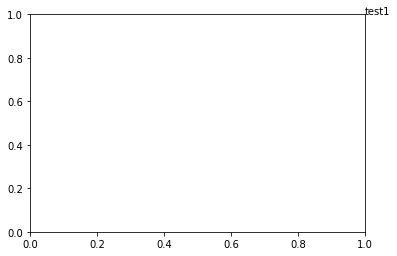

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.annotate("test1",(1,1))
#ax.annotate(["test1","test2"],[(1,1),(2,2)])
plt.show()

## Feature Selection

<div class='alert alert-warning'>
&emsp;After having encoded the categorical feature the dataset contains 79 or 291 features. In both cases, the problem as it is, is a high dimensionality problem. One can wonder wether all features will actually help our model learn and reach higher precision. The greater the dimension, the more chance the model has to overfit the data. It may give too much importance on a certain feature.<br>
&emsp;To do so, several techniques are used, we chose to stay with a tree like technique to stay on the guideline of this notebook.
</div>

In [51]:
def featureSelection(nbFeature, X,Y,outliers_detection=False,X_outliers=None,tree=True,forest=False):
    """Trims the input data to have nbFeature at the end with a single tree or forest technique
    sort_index,X_trimmed = featureSelection(nbFeature, X,Y,tree=True,forest=False)
    """
    if tree: clf = DecisionTreeRegressor()
    elif forest: clf = RandomForestRegressor(n_estimators=100)
    else: raise Exception("Choose a feature selection process true=True or forest=True")
    clf = clf.fit(X, Y)
    feature_importances = clf.feature_importances_
    sort_index = np.argsort(feature_importances)
    kept_columnValues = list(X.columns.values)
    selected_features = np.array(kept_columnValues)[sort_index[:nbFeature]]
    X_trimmed = X.filter(selected_features,axis=1)
    if outliers_detection: X_outliers_trimmed = X_outliers.filter(selected_features,axis=1)
    else: X_outliers_trimmed=None
    return sort_index,X_trimmed,X_outliers_trimmed,feature_importances

In [32]:
nbFeature = X.shape[1]
sort_index,X_trimmed,_,feature_importances = featureSelection(nbFeature, X,Y,tree=True,forest=False)
sort_index_forest,X_trimmed,_,feature_importances_forest = featureSelection(nbFeature, X,Y,tree=False,forest=True)


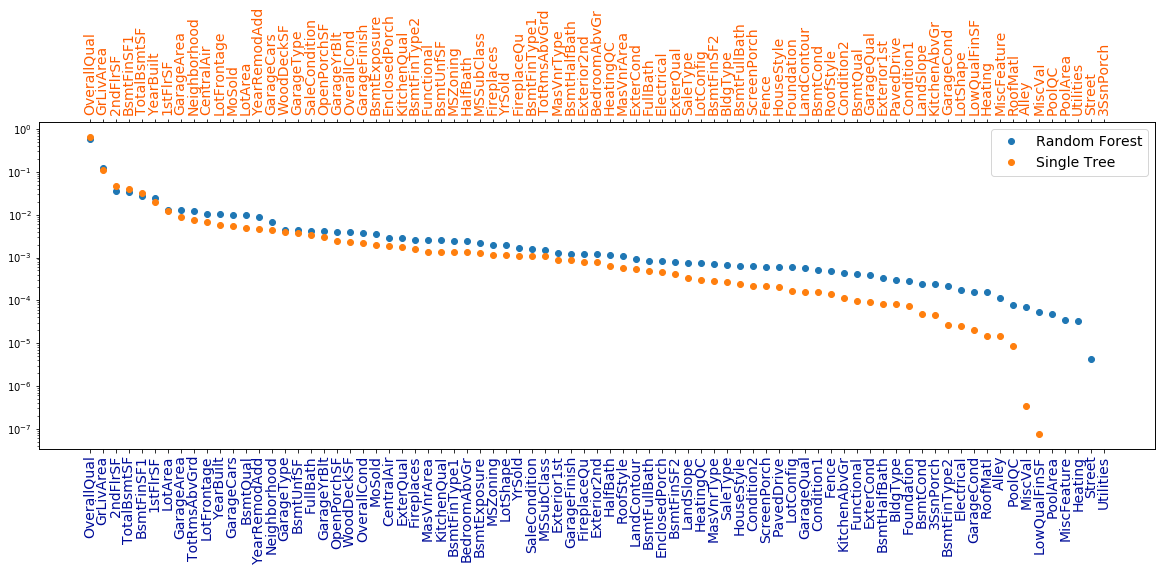

In [33]:
kept_columnValues= list(X.columns.values)
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Random Forest',alpha=1)
locs = ax.set_xticks(np.arange(len(kept_columnValues)))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=14)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(kept_columnValues)))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Single Tree',alpha=1)
ax2.set_xticks(np.arange(len(kept_columnValues)))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=14)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend(fontsize=14)
plt.show()

## PCA?

In [34]:
def PCA(nbPrincipalComponent,X):
    pca = decomposition.PCA(n_components=nbPrincipalComponent)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(i+1) for i in range(nbPrincipalComponent)])
    return(principalDf)

In [87]:
nbPrincipalComponent = 2
pca = decomposition.PCA(n_components=nbPrincipalComponent)
principalComponents = pca.fit_transform(X)
principalDf = PCA(nbPrincipalComponent,X_scaled)


[[-2108.22141589    34.66585902]
 [ -955.26794462   -65.36209144]
 [  691.65286326   136.85265142]
 ...
 [-1716.33079455   -28.36570697]
 [-1464.40910633   -33.94811352]
 [  675.98212166   -84.4671255 ]]


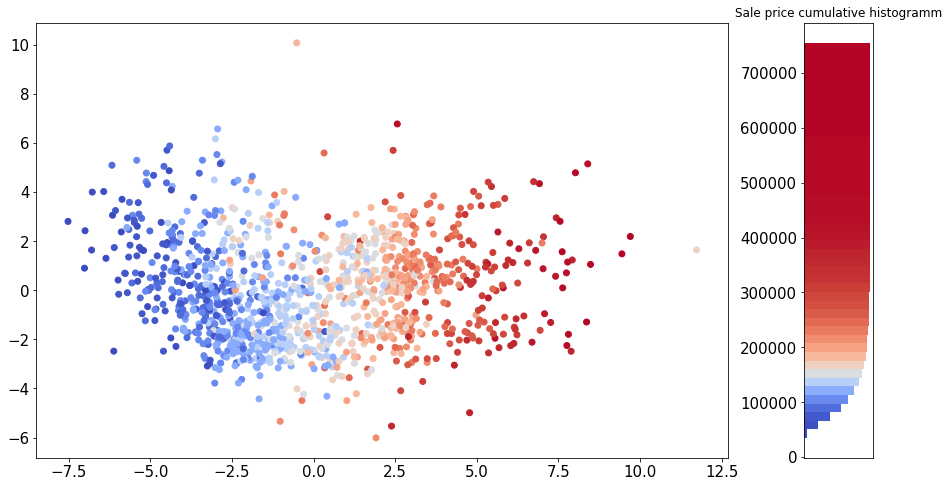

In [36]:
plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(principalDf.pc1,principalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(Y,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

## Building and Training the statistical model

In [37]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    #logRMSE = sum( (estimatedPrice - realPrice)**2 )
    return np.sqrt(logRMSE)
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    foldNb = 0
    kf = KFold(n_splits=nkfold,random_state=42)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    Y_outliers = np.array(Y_outliers)
    if(len(X_outliers)>=nkfold): indexSampleOutliers = zip(kf.split(X),kf.split(X_outliers)) #enough outliers to split them into K fold
    else: indexSampleOutliers = zip(kf.split(X),np.zeros((nkfold,2)))    
    for (train_index, test_index), (outliers_train,outliers_index) in indexSampleOutliers:
        #Reset regressor
        if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
        elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        else: raise Exception("Choose a regression model")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        if(len(X_outliers)>=nkfold):
            X_outliers_test,X_outliers_train = X_outliers[outliers_index],X_outliers[outliers_train] #get a proportinal number of outliers to calculate error
            Y_outliers_test,Y_outliers_train = Y_outliers[outliers_index],Y_outliers[outliers_train]
            X_train = np.concatenate((X_train,X_outliers_train)) #Add the proportion of outliers in the training set
            y_train = np.concatenate((y_train,Y_outliers_train))

        regressor.fit(X_train, y_train)
        y_hat_test = regressor.predict(X_test)
        
        training_estimation = regressor.predict(X_train)
        
        if(len(X_outliers)>=nkfold):
            y_hat_test_outliers = regressor.predict(X_outliers_test)
            y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
            y_test = np.concatenate((y_test,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
        
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

## Executing the pipeline

In [159]:
def pipeline(pdAllData_Categ, encoding_technique='labelEncode', outliers_fraction=0.05, nbFeatures=30, feature_selection_technique='forest', nbPCA=False, regressor='singleTree',  depth=6, min_samples_leaf=8, test_size=0.1, nb_estimator=20):

    #Encoding
    if encoding_technique == 'labelEncode': labelEncode,oneHotEncode= True,False
    elif encoding_technique == 'oneHotEncode': labelEncode,oneHotEncode=False,True
    pdAllData = encodeCategoricalFeatures(pdAllData_Categ,labelEncode=labelEncode,oneHotEncode=oneHotEncode)

    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    Y = pdAllData.SalePrice
    
    #Scaling 
    kept_columnValues = list(X.columns.values)
    X_scaled_array = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    
    #PCA 
    if nbPCA: X_scaled = PCA(nbPCA,X_scaled)
    #Outliers Detection
    scores_pred, y_pred, threshold, X_inliers, Y_inliers, X_outliers, Y_outliers = findOutliers_IsolationForest(X_scaled,X_scaled, Y, outliers_fraction)
    
    #Feature Selection
    if nbFeatures>0:
        if feature_selection_technique == 'tree':tree,forest=True,False
        elif feature_selection_technique == 'forest':tree,forest=False,True

        sort_index,X_trimmed,X_outliers_trimmed,_ = featureSelection(nbFeatures, X_inliers, Y_inliers,outliers_detection=True, X_outliers=X_outliers, tree=tree, forest=forest)
    elif nbFeatures<0:X_trimmed,X_outliers_trimmed = X_inliers,X_outliers
    else: raise Exception('Choose at least 1 feature to be selected or put negative numbers to take all features')
   
    #print('After FeatureSelection',X_trimmed.shape)
    #Learning and evaluation
    if regressor == 'singleTree':singleTree,forest,extraTrees = True,False,False
    elif regressor == 'forest':forest,singleTree,extraTrees = True,False,False
    elif regressor == 'extraTrees':extraTrees,singleTree,forest = True,False,False
    else: raise Exception('Chosoe a regressor model among singleTree, forest, extraTrees')
    test_error, training_error,regressor = regressionTrees(X=X_trimmed,X_outliers=X_outliers_trimmed,Y_outliers=Y_outliers,Y=Y_inliers,depth=depth,min_samples_leaf=min_samples_leaf,test_size=test_size,singleTree=singleTree,forest=forest,extraTrees=extraTrees,nb_estimator=nb_estimator)
    
    return test_error, training_error,regressor

In [118]:
encoding_technique='labelEncode'
outliers_fractionn=0.05
nbFeatures=50
feature_selection_technique='forest'
regressor = 'forest'
nbPCA = False
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
print('Test Error =',test_error,' Train error = ',training_error)

Test Error = 0.23310570537564868  Train error =  0.19811417892306651


## Optimising the pipeline

In [67]:
encoding_techniques=['labelEncode','oneHotEncode']
regressors = ['singleTree','singleTree','forest','forest','extraTrees','extraTrees']
test_errors = np.zeros((2,6))
training_errors = np.zeros((2,6))
for i,encoding_technique in enumerate(encoding_techniques):
    for j,regressor in enumerate(regressors):
        if j>2:nbFeatures=-1
        else: nbFeatures=30
        test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
        test_errors[i,j] = test_error
        training_errors[i,j] = training_error

In [68]:
columns_label =['singleTree','singleTree_no_fs','forest','forest_no_fs','extraTrees','extraTrees_no_fs']
results = pd.DataFrame(data=test_errors,index=encoding_techniques,columns=columns_label)
results

singleTree  singleTree_no_fs    forest  forest_no_fs  \
labelEncode     0.302895          0.307722  0.299660      0.159073   
oneHotEncode    0.401163          0.411771  0.411587      0.159913   

              extraTrees  extraTrees_no_fs  
labelEncode     0.222007          0.222007  
oneHotEncode    0.233591          0.233591

#### Number of features selected

In [70]:
regressor = 'forest'
nbFeatures_list = np.arange(1,80,5)
nbFeatures_list_hot = np.arange(1,293,10)
test_errors_labelEncode = []
train_errors_labelEncode = []

test_errors_hotEncode = []
train_errors_hotEncode = []

for nbFeatures in nbFeatures_list:
    test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='labelEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode.append(test_error)
    train_errors_labelEncode.append(training_error)
for nbFeatures in nbFeatures_list_hot:
    test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='oneHotEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode.append(test_error)
    train_errors_hotEncode.append(training_error)



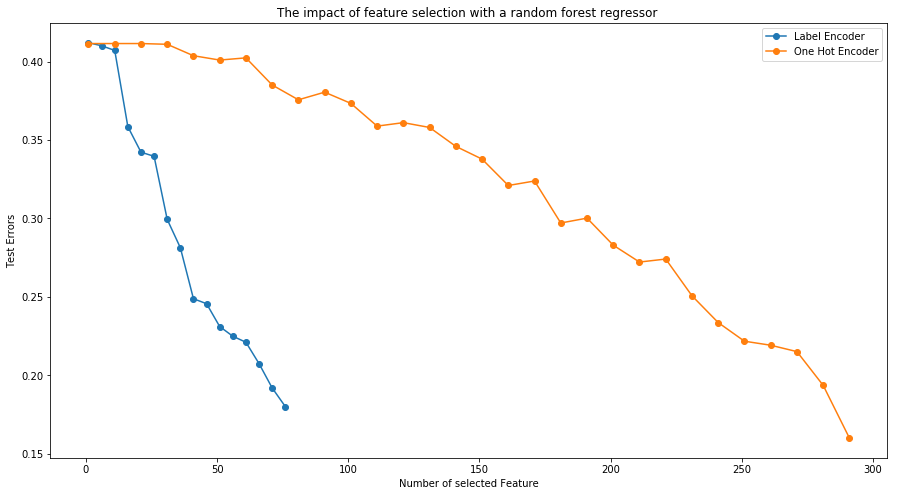

In [74]:
plt.figure(figsize=(15,8))
plt.title('The impact of feature selection with a random forest regressor ')
plt.plot(nbFeatures_list,test_errors_labelEncode,'-o',label='Label Encoder')
plt.plot(nbFeatures_list_hot,test_errors_hotEncode,'-o',label='One Hot Encoder')
plt.ylabel('Test Errors')
plt.xlabel('Number of selected Feature')
plt.legend()
plt.show()

In [103]:
regressor = 'forest'
pca_list = np.arange(1,80,5)
pca_list_hot = np.arange(1,293,10)
nbFeatures = -1
test_errors_labelEncode_pca = []
train_errors_labelEncode_pca = []

test_errors_hotEncode_pca = []
train_errors_hotEncode_pca = []

for nbPCA in pca_list:
    test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='labelEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode_pca.append(test_error)
    train_errors_labelEncode_pca.append(training_error)
for nbPCA in pca_list_hot:
    test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='oneHotEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode_pca.append(test_error)
    train_errors_hotEncode_pca.append(training_error)



(1200, 1)
(1200, 6)
(1200, 11)
(1200, 16)
(1200, 21)
(1200, 26)
(1200, 31)
(1200, 36)
(1200, 41)
(1200, 46)
(1200, 51)
(1200, 56)
(1200, 61)
(1200, 66)
(1200, 71)
(1200, 76)
(1200, 1)
(1200, 11)
(1200, 21)
(1200, 31)
(1200, 41)
(1200, 51)
(1200, 61)
(1200, 71)
(1200, 81)
(1200, 91)
(1200, 101)
(1200, 111)
(1200, 121)
(1200, 131)
(1200, 141)
(1200, 151)
(1200, 161)
(1200, 171)
(1200, 181)
(1200, 191)
(1200, 201)
(1200, 211)
(1200, 221)
(1200, 231)
(1200, 241)
(1200, 251)
(1200, 261)
(1200, 271)
(1200, 281)
(1200, 291)


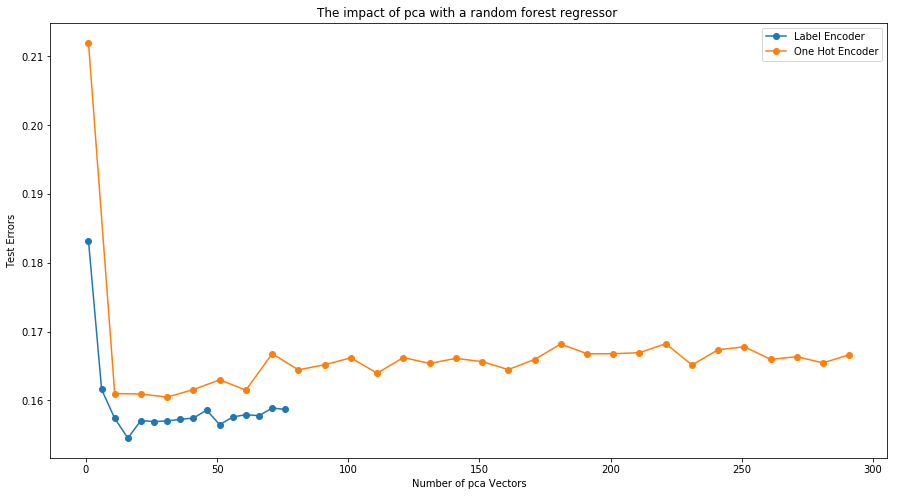

In [105]:
plt.figure(figsize=(15,8))
plt.title('The impact of pca with a random forest regressor ')
plt.plot(pca_list,test_errors_labelEncode_pca,'-o',label='Label Encoder')
plt.plot(pca_list_hot,test_errors_hotEncode_pca,'-o',label='One Hot Encoder')
plt.ylabel('Test Errors')
plt.xlabel('Number of pca Vectors')
plt.legend()
plt.show()

In [160]:
nbFeatures_list = np.arange(1,80,2)
pca_list = np.arange(1,80,2)
features_grid, pca_grid = np.meshgrid(nbFeatures_list,pca_list)
           

In [ ]:
test_error_grid = np.zeros(features_grid.shape)
train_error_grid = np.zeros(features_grid.shape)
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):            
        if(i<=j): #The PCA is done before the feature selection 
            test_error, training_error,_ = pipeline(pdAllData_Categ, encoding_technique='labelEncode', outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, regressor=regressor,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
            test_error_grid[i,j] = test_error
            train_error_grid[i,j] = training_error
    print(j,' PCA DONE')

0  PCA DONE
1  PCA DONE
2  PCA DONE
3  PCA DONE
4  PCA DONE
5  PCA DONE
6  PCA DONE
7  PCA DONE
8  PCA DONE
9  PCA DONE
10  PCA DONE
11  PCA DONE
12  PCA DONE
13  PCA DONE
14  PCA DONE
15  PCA DONE
16  PCA DONE
17  PCA DONE
18  PCA DONE
19  PCA DONE


In [162]:
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):
        if(i>j): #The PCA is done before the featue selection 
            test_error_grid[i,j] = 0.4
            train_error_grid[i,j] = 0.4

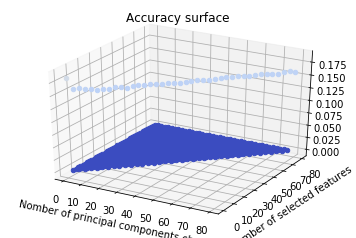

In [163]:
fig = plt.figure()
ax = fig.gca(projection='3d')
max_err = np.max(test_error_grid)
min_err = np.min(test_error_grid)
for j,nbPCA in enumerate(pca_list):
    for i,nbFeatures in enumerate(nbFeatures_list):
        if i<=j:
            color = (test_error_grid[i,j]-min_err)/(max_err-min_err)
            ax.scatter(pca_grid[i,j],features_grid[i,j],test_error_grid[i,j],c = cm.coolwarm(color))
plt.title('Accuracy surface')
plt.ylabel('Nomber of selected features')
plt.xlabel('Nomber of principal components chosen')
plt.show()

In [148]:
min_err

0.15590974846907352

### Grid Search

In [157]:
depth_list = np.arange(1,21)
min_samples_leaf_list = np.arange(1,40)
depth_grid,min_samples_leaf_grid = np.meshgrid(depth_list,min_samples_leaf_list)